In [242]:
FILE_NAME = 'magazine_dataset.csv'

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from sklearn.preprocessing import MinMaxScaler

tf.__version__

'2.0.0'

In [243]:
def plot_series(time, series, lab, form='-', start=0, end=None):
    plt.plot(time[start:end], series[start:end], form, label=lab)
    plt.xlabel("Minuto")
    plt.ylabel("Preço")
    plt.grid(True)
    
def split_dataset(dataset):
    size = dataset.shape[0]
    train_size = size * 80 // 100
    test_size = (size - train_size) // 2
    
    return dataset[0:train_size, :], dataset[train_size:(train_size + test_size), :], dataset[(train_size + test_size):size, :]

def windowed_dataset(series_x, series_y, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices((series_x, series_y))
    ds = ds.shuffle(shuffle_buffer)

    return ds.batch(batch_size).prefetch(1).repeat()

In [244]:
data = pd.read_csv(FILE_NAME, sep=',')
data = data[['open', 'high', 'low', 'close', 'dollar_close', 'volume', 'sentiment_polarity', 'close']]
data.columns.values[7] = "y"
data.head()

,open,high,low,close,dollar_close,volume,sentiment_polarity,y
0,33.0013,33.0316,32.7213,32.8513,4.1007,0,0.06801,32.8513
1,32.8810,33.1225,32.8522,33.0411,4.0994,301337,0.06801,33.0411
2,33.0200,33.3100,33.0200,33.1300,4.0979,177100,0.06801,33.1300
3,33.1506,33.1761,32.9759,33.0006,4.0971,179428,0.06801,33.0006
4,33.0012,33.1010,32.9008,32.9112,4.0974,204443,0.06801,32.9112


In [245]:
dataset = data['y']
dataset.loc[dataset.shape[0]]= 0.0
dataset = dataset.iloc[1:]
data.iloc[:, -1] = dataset.values
dataset = data[:-1]

dataset_to_numpy = dataset.values
dataset.head()

,open,high,low,close,dollar_close,volume,sentiment_polarity,y
0,33.0013,33.0316,32.7213,32.8513,4.1007,0,0.06801,33.0411
1,32.8810,33.1225,32.8522,33.0411,4.0994,301337,0.06801,33.1300
2,33.0200,33.3100,33.0200,33.1300,4.0979,177100,0.06801,33.0006
3,33.1506,33.1761,32.9759,33.0006,4.0971,179428,0.06801,32.9112
4,33.0012,33.1010,32.9008,32.9112,4.0974,204443,0.06801,32.8800


In [246]:
train_dataset, cross_validation_dataset, dev_dataset = split_dataset(dataset_to_numpy)

print("Dataset shape: {:s}".format(str(dataset_to_numpy.shape)))
print("Train dataset shape: {:s}".format(str(train_dataset.shape)))
print("Cross validation dataset shape: {:s}".format(str(cross_validation_dataset.shape)))
print("Dev dataset shape: {:s}".format(str(dev_dataset.shape)))

Dataset shape: (11796, 8)
Train dataset shape: (9436, 8)
Cross validation dataset shape: (1180, 8)
Dev dataset shape: (1180, 8)


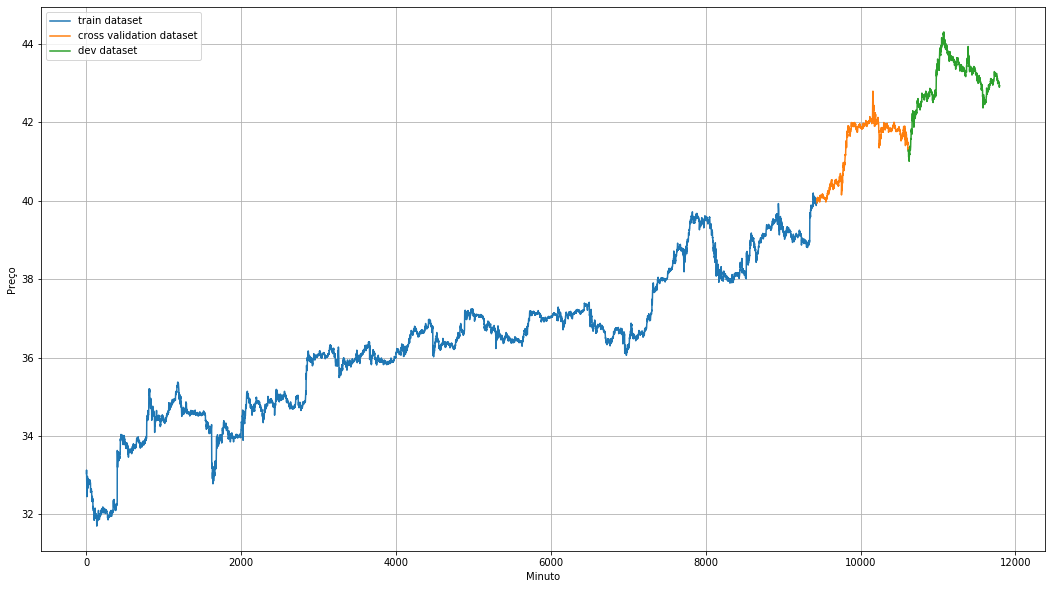

In [247]:
plt.figure(figsize=(18, 10))
plot_series(np.arange(train_dataset.shape[0]), train_dataset[:, -1], "train dataset")
plot_series(np.arange(train_dataset.shape[0], (cross_validation_dataset.shape[0] + train_dataset.shape[0])), cross_validation_dataset[:, -1], "cross validation dataset")
plot_series(np.arange((cross_validation_dataset.shape[0] + train_dataset.shape[0]), (cross_validation_dataset.shape[0]+ train_dataset.shape[0] + dev_dataset.shape[0])), dev_dataset[:, -1], "dev dataset")
plt.legend(loc='upper left')

# Data normalization

In [252]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_dataset[:, 0:-1])
train_dataset_normalized = scaler.transform(train_dataset[:, 0:-1])
cross_validation_dataset_normalized = scaler.transform(cross_validation_dataset[:, 0:-1])
dev_dataset_normalized = scaler.transform(dev_dataset[:, 0:-1])

In [253]:
train_set = windowed_dataset(train_dataset_normalized[:, :, np.newaxis], train_dataset[:, -1], 128, 1000)
cross_validation_set = windowed_dataset(cross_validation_dataset_normalized[:, :, np.newaxis], cross_validation_dataset[:, -1], 128, 1000)
dev_set = windowed_dataset(dev_dataset_normalized[:, :, np.newaxis], dev_dataset[:, -1], 128, 1000)

In [254]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100)
])

model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.RMSprop(lr=1e-8, momentum=0.9), metrics=['mae'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, None, 64)          384       
_________________________________________________________________
lstm_20 (LSTM)               (None, None, 128)         98816     
_________________________________________________________________
lstm_21 (LSTM)               (None, None, 128)         131584    
_________________________________________________________________
dense_30 (Dense)             (None, None, 64)          8256      
_________________________________________________________________
dense_31 (Dense)             (None, None, 10)          650       
_________________________________________________________________
dense_32 (Dense)             (None, None, 1)           11        
_________________________________________________________________
lambda_10 (Lambda)           (None, None, 1)         

In [128]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
history = model.fit(train_set, epochs=100, steps_per_epoch=100, callbacks=[lr_schedule])

Train for 100 steps
Epoch 1/100
100/100 [==============================] - 4s 42ms/step - loss: 1140.3588 - mae: 33.4896
Epoch 2/100
100/100 [==============================] - 1s 12ms/step - loss: 1102.6181 - mae: 32.9325: 0s - loss: 1113.6235 - 
Epoch 3/100
100/100 [==============================] - 1s 11ms/step - loss: 1049.2575 - mae: 32.1248
Epoch 4/100
100/100 [==============================] - 1s 10ms/step - loss: 991.9068 - mae: 31.2090
Epoch 5/100
100/100 [==============================] - 1s 10ms/step - loss: 923.7066 - mae: 30.0881
Epoch 6/100
100/100 [==============================] - 1s 10ms/step - loss: 857.1371 - mae: 28.9250
Epoch 7/100
100/100 [==============================] - 1s 10ms/step - loss: 789.0625 - mae: 27.6701
Epoch 8/100
100/100 [==============================] - 1s 10ms/step - loss: 726.1668 - mae: 26.4077
Epoch 9/100
100/100 [==============================] - 1s 10ms/step - loss: 643.2257 - mae: 24.6208
Epoch 10/100
100/100 [==============================

100/100 [==============================] - 1s 10ms/step - loss: 0.6570 - mae: 0.6639
Epoch 84/100
100/100 [==============================] - 1s 10ms/step - loss: 0.3779 - mae: 0.4949
Epoch 85/100
100/100 [==============================] - 1s 10ms/step - loss: 0.4794 - mae: 0.5564
Epoch 86/100
100/100 [==============================] - 1s 11ms/step - loss: 0.6861 - mae: 0.6808
Epoch 87/100
100/100 [==============================] - 1s 10ms/step - loss: 0.8143 - mae: 0.7101
Epoch 88/100
100/100 [==============================] - 1s 10ms/step - loss: 0.7151 - mae: 0.6900
Epoch 89/100
100/100 [==============================] - 1s 10ms/step - loss: 0.5092 - mae: 0.5964
Epoch 90/100
100/100 [==============================] - 1s 10ms/step - loss: 0.8657 - mae: 0.7595
Epoch 91/100
100/100 [==============================] - 1s 10ms/step - loss: 0.7834 - mae: 0.7027
Epoch 92/100
100/100 [==============================] - 1s 10ms/step - loss: 0.9722 - mae: 0.8099
Epoch 93/100
100/100 [===========